In [1]:
%pip install  edge-ml

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np

In [3]:
from edgeml import DatasetReceiver

In [4]:
project=DatasetReceiver("https://beta.edge-ml.org","02a4fad735d3308b68672ddb7593f047")
project.loadData()

In [5]:
import pickle
pickle.dump(project, open("data_snapshot/project_css25.pkl","wb"))

In [6]:
import pickle
project=pickle.load(open("data_snapshot/project_css25.pkl","rb"))

In [7]:
df=pd.concat([d.data.iloc[40:-40].dropna().assign(**d.metaData) for d  in project.datasets if (d.name == "devicemotion" and d.data.shape[0]>0) and d.timeSeries[0].end-d.timeSeries[0].start>10000] )
df

,time,acceleration.x,acceleration.y,acceleration.z,accelerationIncludingGravity.x,accelerationIncludingGravity.y,accelerationIncludingGravity.z,rotationRate.alpha,rotationRate.beta,rotationRate.gamma,activity,participantId,mobile,browser
40,2025-06-03 12:01:23.600,0.0,0.0,-0.2,-0.7,8.5,4.9,2.3,0.100000,-0.900000,sitting,10d83,UnknownPhone,Chrome
41,2025-06-03 12:01:23.616,0.0,0.0,-0.1,-0.7,8.5,4.9,0.8,-0.400000,-0.900000,sitting,10d83,UnknownPhone,Chrome
42,2025-06-03 12:01:23.632,-0.1,0.0,-0.1,-0.7,8.6,5.0,-0.9,-1.100000,-0.700000,sitting,10d83,UnknownPhone,Chrome
43,2025-06-03 12:01:23.649,-0.1,0.1,0.0,-0.8,8.5,5.1,-2.4,-1.400000,0.400000,sitting,10d83,UnknownPhone,Chrome
44,2025-06-03 12:01:23.666,-0.1,0.0,0.1,-0.8,8.5,5.1,-2.4,-1.400000,0.400000,sitting,10d83,UnknownPhone,Chrome
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1618,2025-07-07 14:36:19.243,-0.1,0.0,0.6,0.3,5.2,8.7,14.4,-21.900000,15.200000,standing,152a7,UnknownPhone,Chrome
1619,2025-07-07 14:36:19.260,-0.1,-0.1,0.4,0.3,5.2,8.4,16.5,-25.100000,16.500000,standing,152a7,UnknownPhone,Chrome
1620,2025-07-07 14:36:19.277,-0.2,0.0,0.1,0.4,5.3,8.2,17.6,-26.200001,17.200001,standing,152a7,UnknownPhone,Chrome
1621,2025-07-07 14:36:19.293,-0.1,0.0,0.0,0.7,5.4,8.2,19.1,-26.799999,15.600000,standing,152a7,UnknownPhone,Chrome


(array([59963.,     0.,     0., 44676.,     0.,     0.,  9712.,     0.,
            0., 15240.]),
 array([0. , 0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.1, 2.4, 2.7, 3. ]),
 <BarContainer object of 10 artists>)

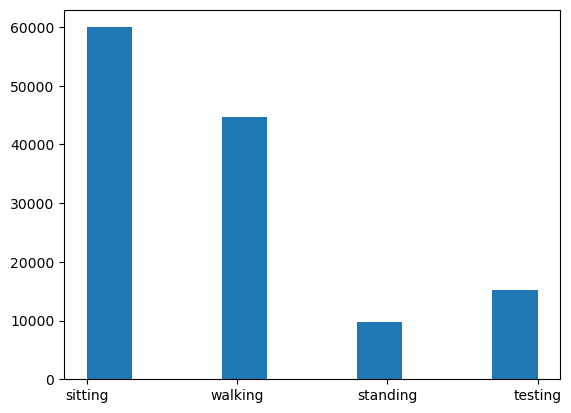

In [8]:
import matplotlib.pyplot as plt
plt.hist(df["activity"])

In [9]:
df2=df[df.activity!="testing"]
df2=pd.concat([df2.drop(columns=["mobile","browser"]),pd.get_dummies(df2[["browser"]])], axis=1)

df2.index=df2.time
df2=df2.drop(columns="time")
df2["activity"],labels=df2["activity"].factorize()
df2

,acceleration.x,acceleration.y,acceleration.z,accelerationIncludingGravity.x,accelerationIncludingGravity.y,accelerationIncludingGravity.z,rotationRate.alpha,rotationRate.beta,rotationRate.gamma,activity,participantId,browser_Chrome,browser_Safari
time,,,,,,,,,,,,,
2025-06-03 12:01:23.600,0.0,0.0,-0.2,-0.7,8.5,4.9,2.3,0.100000,-0.900000,0,10d83,True,False
2025-06-03 12:01:23.616,0.0,0.0,-0.1,-0.7,8.5,4.9,0.8,-0.400000,-0.900000,0,10d83,True,False
2025-06-03 12:01:23.632,-0.1,0.0,-0.1,-0.7,8.6,5.0,-0.9,-1.100000,-0.700000,0,10d83,True,False
2025-06-03 12:01:23.649,-0.1,0.1,0.0,-0.8,8.5,5.1,-2.4,-1.400000,0.400000,0,10d83,True,False
2025-06-03 12:01:23.666,-0.1,0.0,0.1,-0.8,8.5,5.1,-2.4,-1.400000,0.400000,0,10d83,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-07-07 14:36:19.243,-0.1,0.0,0.6,0.3,5.2,8.7,14.4,-21.900000,15.200000,2,152a7,True,False
2025-07-07 14:36:19.260,-0.1,-0.1,0.4,0.3,5.2,8.4,16.5,-25.100000,16.500000,2,152a7,True,False
2025-07-07 14:36:19.277,-0.2,0.0,0.1,0.4,5.3,8.2,17.6,-26.200001,17.200001,2,152a7,True,False


In [10]:
df2.dtypes

acceleration.x                    float32
acceleration.y                    float32
acceleration.z                    float32
accelerationIncludingGravity.x    float32
accelerationIncludingGravity.y    float32
accelerationIncludingGravity.z    float32
rotationRate.alpha                float32
rotationRate.beta                 float32
rotationRate.gamma                float32
activity                            int64
participantId                      object
browser_Chrome                       bool
browser_Safari                       bool
dtype: object

In [11]:
def mode(x): 
    return (x.mode()[0])

aggs={ 
      **dict.fromkeys(df2.select_dtypes(exclude=[np.float32]).columns, [ mode ]),
      **dict.fromkeys(df2.select_dtypes(include=[np.float32]).columns, ["mean","var","min","max","median"]),
      "activity": [mode,'count'],
}

del(aggs["participantId"])
aggs

{'activity': [<function __main__.mode(x)>, 'count'],
 'browser_Chrome': [<function __main__.mode(x)>],
 'browser_Safari': [<function __main__.mode(x)>],
 'acceleration.x': ['mean', 'var', 'min', 'max', 'median'],
 'acceleration.y': ['mean', 'var', 'min', 'max', 'median'],
 'acceleration.z': ['mean', 'var', 'min', 'max', 'median'],
 'accelerationIncludingGravity.x': ['mean', 'var', 'min', 'max', 'median'],
 'accelerationIncludingGravity.y': ['mean', 'var', 'min', 'max', 'median'],
 'accelerationIncludingGravity.z': ['mean', 'var', 'min', 'max', 'median'],
 'rotationRate.alpha': ['mean', 'var', 'min', 'max', 'median'],
 'rotationRate.beta': ['mean', 'var', 'min', 'max', 'median'],
 'rotationRate.gamma': ['mean', 'var', 'min', 'max', 'median']}

In [12]:
df3=df2.groupby("participantId").rolling("1s").agg(aggs)
df3.columns = [col[0] + "_" + col[1] if col [1] != "mode" else col[0] for col in df3.columns]
df3

activity  activity_count  \
participantId time                                                
10d83         2025-06-03 12:01:23.600       0.0             1.0   
              2025-06-03 12:01:23.616       0.0             2.0   
              2025-06-03 12:01:23.632       0.0             3.0   
              2025-06-03 12:01:23.649       0.0             4.0   
              2025-06-03 12:01:23.666       0.0             5.0   
...                                         ...             ...   
uspgb         2025-06-23 20:26:23.914       0.0            60.0   
              2025-06-23 20:26:23.930       0.0            61.0   
              2025-06-23 20:26:23.947       0.0            60.0   
              2025-06-23 20:26:23.964       0.0            60.0   
              2025-06-23 20:26:23.980       0.0            61.0   

                                       browser_Chrome  browser_Safari  \
participantId time                                                      
10d83         2025-06-03 12:01:23.600             1.0             0.0   
              2025-06-03 12:01:23.616             1.0             0.0   
              2025-06-03 12:01:23.632             1.0             0.0   
              2025-06-03 12:01:23.649             1.0             0.0   
              2025-06-03 12:01:23.666             1.0             0.0   
...                                               ...             ...   
uspgb         2025-06-23 20:26:23.914             1.0             0.0   
              2025-06-23 20:26:23.930             1.0             0.0   
              2025-06-23 20:26:23.947             1.0             0.0   
              2025-06-23 20:26:23.964             1.0             0.0   
              2025-06-23 20:26:23.980             1.0             0.0   

                                       acceleration.x_mean  \
participantId time                                           
10d83         2025-06-03 12:01:23.600             0.000000   
              2025-06-03 12:01:23.616             0.000000   
              2025-06-03 12:01:23.632            -0.033333   
              2025-06-03 12:01:23.649            -0.050000   
              2025-06-03 12:01:23.666            -0.060000   
...                                                    ...   
uspgb         2025-06-23 20:26:23.914             0.000000   
              2025-06-23 20:26:23.930             0.000000   
              2025-06-23 20:26:23.947             0.000000   
              2025-06-23 20:26:23.964             0.000000   
              2025-06-23 20:26:23.980             0.000000   

                                       acceleration.x_var  acceleration.x_min  \
participantId time                                                              
10d83         2025-06-03 12:01:23.600                 NaN                 0.0   
              2025-06-03 12:01:23.616            0.000000                 0.0   
              2025-06-03 12:01:23.632            0.003333                -0.1   
              2025-06-03 12:01:23.649            0.003333                -0.1   
              2025-06-03 12:01:23.666            0.003000                -0.1   
...                                                   ...                 ...   
uspgb         2025-06-23 20:26:23.914            0.000000                 0.0   
              2025-06-23 20:26:23.930            0.000000                 0.0   
              2025-06-23 20:26:23.947            0.000000                 0.0   
              2025-06-23 20:26:23.964            0.000000                 0.0   
              2025-06-23 20:26:23.980            0.000000                 0.0   

                                       acceleration.x_max  \
participantId time                                          
10d83         2025-06-03 12:01:23.600                 0.0   
              2025-06-03 12:01:23.616                 0.0   
              2025-06-03 12:01:23.632                 0.0   
              2025-06-03 12:01:23.649              

In [13]:
df4=df3[df3.activity_count >= 60 ].copy()
df4.index=df4.index.droplevel(1)
df4=df4.reset_index()

df4.dropna(inplace=True)

df4.activity=df4.activity.apply(lambda x: labels[int(x)])
df4

,participantId,activity,activity_count,browser_Chrome,browser_Safari,acceleration.x_mean,acceleration.x_var,acceleration.x_min,acceleration.x_max,acceleration.x_median,...,rotationRate.beta_mean,rotationRate.beta_var,rotationRate.beta_min,rotationRate.beta_max,rotationRate.beta_median,rotationRate.gamma_mean,rotationRate.gamma_var,rotationRate.gamma_min,rotationRate.gamma_max,rotationRate.gamma_median
0,10d83,sitting,60.0,1.0,0.0,0.008333,0.011624,-0.2,0.3,0.0,...,-0.355000,1.314720,-2.7,3.6,-0.45,0.015000,0.912483,-1.5,3.0,0.05
1,10d83,sitting,61.0,1.0,0.0,0.008197,0.011432,-0.2,0.3,0.0,...,-0.324590,1.349219,-2.7,3.6,-0.40,0.011475,0.898033,-1.5,3.0,0.00
2,10d83,sitting,60.0,1.0,0.0,0.008333,0.011624,-0.2,0.3,0.0,...,-0.300000,1.424746,-2.7,3.6,-0.40,0.038333,0.885116,-1.5,3.0,0.05
3,10d83,sitting,60.0,1.0,0.0,0.011667,0.011556,-0.2,0.3,0.0,...,-0.255000,1.473025,-2.7,3.6,-0.30,0.040000,0.882780,-1.5,3.0,0.05
4,10d83,sitting,60.0,1.0,0.0,0.015000,0.011466,-0.2,0.3,0.0,...,-0.201667,1.519489,-2.7,3.6,-0.30,0.006667,0.925040,-1.6,3.0,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
108191,uspgb,sitting,60.0,1.0,0.0,0.000000,0.000000,0.0,0.0,0.0,...,0.185000,0.755534,-1.7,2.1,0.30,0.046667,0.002531,0.0,0.1,0.00
108192,uspgb,sitting,61.0,1.0,0.0,0.000000,0.000000,0.0,0.0,0.0,...,0.191803,0.745765,-1.7,2.1,0.30,0.045902,0.002525,0.0,0.1,0.00
108193,uspgb,sitting,60.0,1.0,0.0,0.000000,0.000000,0.0,0.0,0.0,...,0.160000,0.712271,-1.7,2.1,0.30,0.045000,0.002517,0.0,0.1,0.00
108194,uspgb,sitting,60.0,1.0,0.0,0.000000,0.000000,0.0,0.0,0.0,...,0.148333,0.691014,-1.7,2.1,0.30,0.043333,0.002497,0.0,0.1,0.00


In [14]:
pickle.dump(df4,open("../features.pkl","wb"))

In [ ]:
%pip install imblearn

In [31]:
X, y = RandomUnderSampler().fit_resample(df4.drop(columns=["activity"]), df4.activity)
groups=X.participantId
X.drop(columns=["participantId"], inplace=True)

/tmp/ipykernel_1064/561568299.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df5["activity"]=y


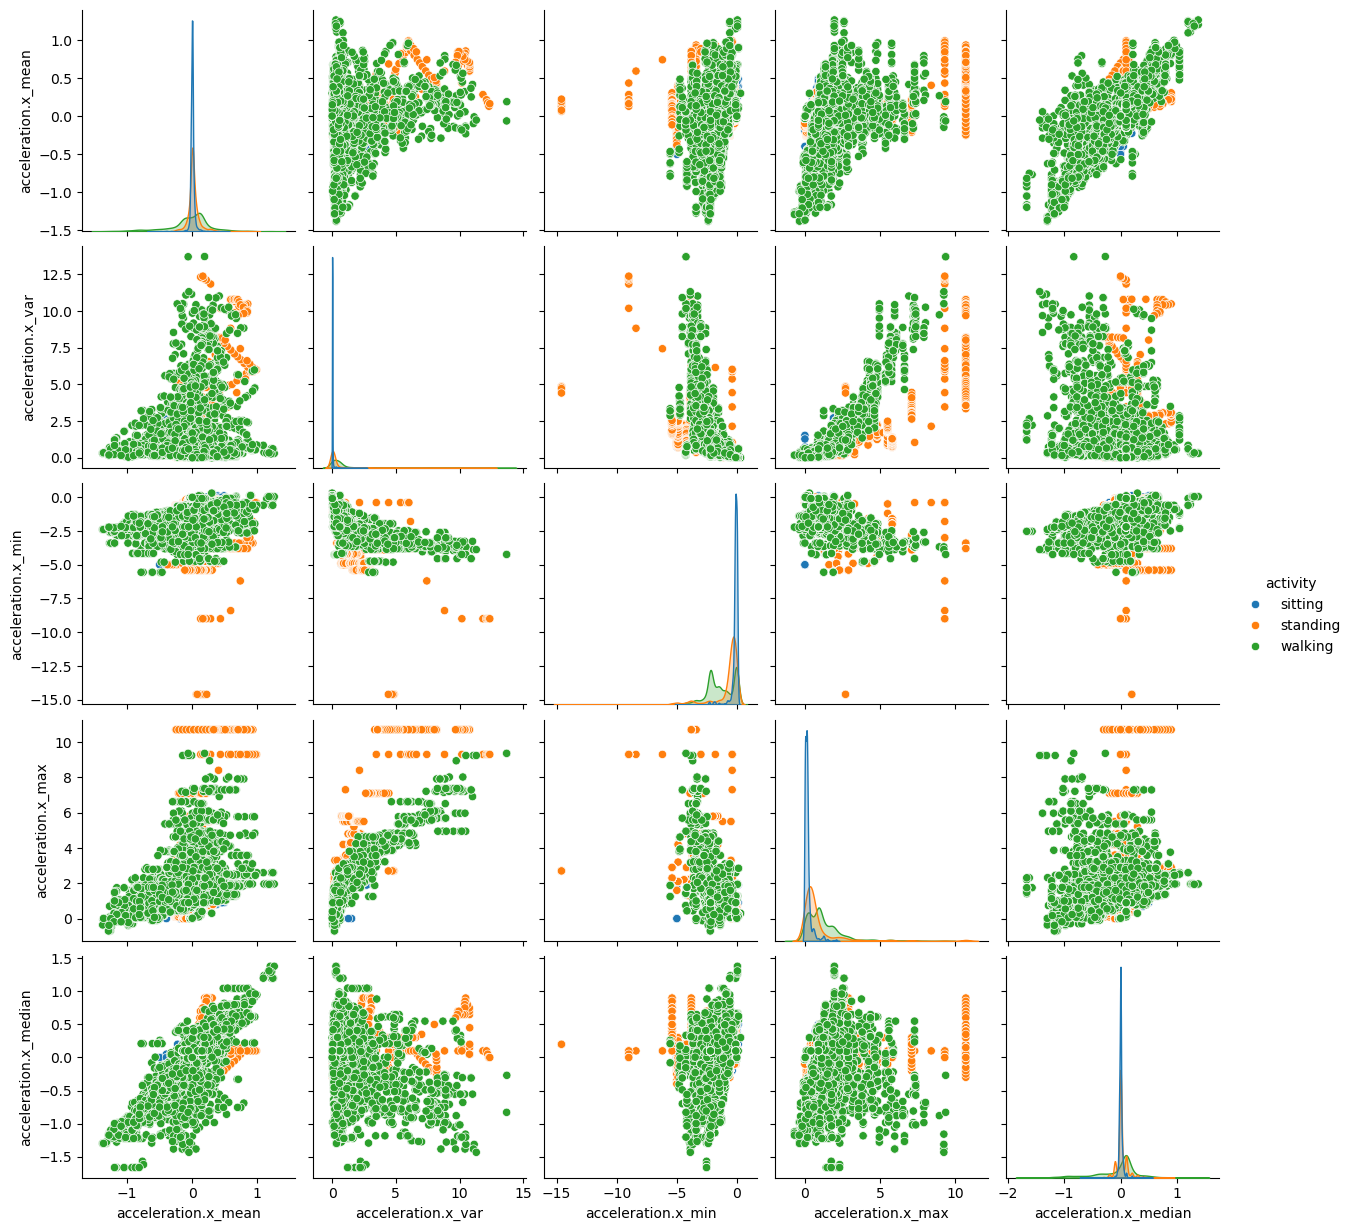

In [33]:
import seaborn as sns
df5=X[[col for col in X.columns if col.startswith("acceleration.x_")]]
df5["activity"]=y

sns.pairplot(df5, hue="activity")

Note: you may need to restart the kernel to use updated packages.


In [46]:
from sklearn.model_selection import cross_validate,LeaveOneGroupOut
from sklearn.tree import DecisionTreeClassifier

classifier_metrics = [
    "accuracy", "balanced_accuracy", "precision_macro", "recall_macro",
    "f1_macro"
]

scores=pd.DataFrame(cross_validate(DecisionTreeClassifier(), X, y, cv=LeaveOneGroupOut(), groups=groups, scoring=classifier_metrics , verbose = True))

scores

/opt/conda/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/conda/lib/python3.12/site-packages/sklearn/metrics/_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
/opt/conda/lib/python3.12/site-packages/sklearn/metrics/_classification.py:2524: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/opt/conda/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this be

,fit_time,score_time,test_accuracy,test_balanced_accuracy,test_precision_macro,test_recall_macro,test_f1_macro
0,0.499771,0.014843,0.187532,0.375221,0.360808,0.375221,0.195355
1,0.447305,0.048324,0.507309,0.500000,0.253655,0.500000,0.336566
2,0.571851,0.012613,1.000000,1.000000,1.000000,1.000000,1.000000
3,0.533087,0.006315,0.026786,0.026786,0.333333,0.008929,0.017391
4,0.606293,0.010045,0.000000,0.000000,0.000000,0.000000,0.000000
5,0.499916,0.012411,0.007874,0.007874,0.333333,0.002625,0.005208
6,0.596847,0.007824,1.000000,1.000000,1.000000,1.000000,1.000000
7,0.610137,0.006098,0.833333,0.833333,0.500000,0.416667,0.454545
8,0.621797,0.007752,1.000000,1.000000,1.000000,1.000000,1.000000
9,0.619799,0.007133,1.000000,1.000000,1.000000,1.000000,1.000000


In [47]:
scores.mean()

fit_time                  0.584153
score_time                0.012553
test_accuracy             0.641587
test_balanced_accuracy    0.651006
test_precision_macro      0.571167
test_recall_macro         0.501151
test_f1_macro             0.498090
dtype: float64

In [51]:
from sklearn.feature_selection import RFECV
from sklearn.model_selection import GroupKFold

rfecv=RFECV(estimator=DecisionTreeClassifier(), cv=GroupKFold(n_splits=5), step=1 , verbose=1, scoring='f1_macro').fit(X,y,groups=groups)


Fitting estimator with 48 features.
Fitting estimator with 47 features.
Fitting estimator with 46 features.
Fitting estimator with 45 features.
Fitting estimator with 44 features.
Fitting estimator with 43 features.
Fitting estimator with 42 features.
Fitting estimator with 41 features.
Fitting estimator with 40 features.
Fitting estimator with 39 features.
Fitting estimator with 38 features.
Fitting estimator with 37 features.
Fitting estimator with 36 features.
Fitting estimator with 35 features.
Fitting estimator with 34 features.
Fitting estimator with 33 features.
Fitting estimator with 32 features.
Fitting estimator with 31 features.
Fitting estimator with 30 features.
Fitting estimator with 29 features.
Fitting estimator with 28 features.
Fitting estimator with 27 features.
Fitting estimator with 26 features.
Fitting estimator with 25 features.
Fitting estimator with 24 features.
Fitting estimator with 23 features.
Fitting estimator with 22 features.
Fitting estimator with 21 fe

In [53]:
# Print the optimal number of features and their indices
print("Optimal number of features : %d" % rfecv.n_features_)
print("Selected features : %s" % rfecv.support_)
print("Feature ranking : %s" % rfecv.ranking_)

Optimal number of features : 9
Selected features : [ True False False False False False False False False False False  True
 False False  True  True False False False False  True False  True False
 False False  True False False False False  True False False  True False
 False False False False False False False False False False False False]
Feature ranking : [ 1 16 40 12 39 32 18 19  2 11 36  1  9 20  1  1 34 13 33 31  1  7  1  8
 24  3  1 38 37 35 10  1 14 25  1  5 23 26 28 21 22 15 29 27  4 30  6 17]


In [54]:
cv_results = pd.DataFrame(rfecv.cv_results_)
cv_results


,mean_test_score,std_test_score,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,n_features
0,0.436948,0.071824,0.366104,0.431553,0.350384,0.518543,0.518154,1
1,0.365234,0.101369,0.336566,0.281080,0.259869,0.408864,0.539789,2
2,0.344917,0.134205,0.336566,0.121726,0.534643,0.325201,0.406447,3
3,0.439650,0.129188,0.336566,0.326164,0.526379,0.652879,0.356259,4
4,0.393418,0.183278,0.336566,0.168898,0.724361,0.410832,0.326432,5
5,0.409741,0.205130,0.336566,0.103404,0.730267,0.497192,0.381274,6
6,0.403519,0.195950,0.336566,0.107266,0.706498,0.488964,0.378301,7
7,0.415540,0.090524,0.336566,0.303956,0.545871,0.487397,0.403908,8
8,0.461309,0.129404,0.336566,0.368939,0.691460,0.512148,0.397432,9
9,0.402506,0.140002,0.336566,0.178846,0.581892,0.509472,0.405752,10


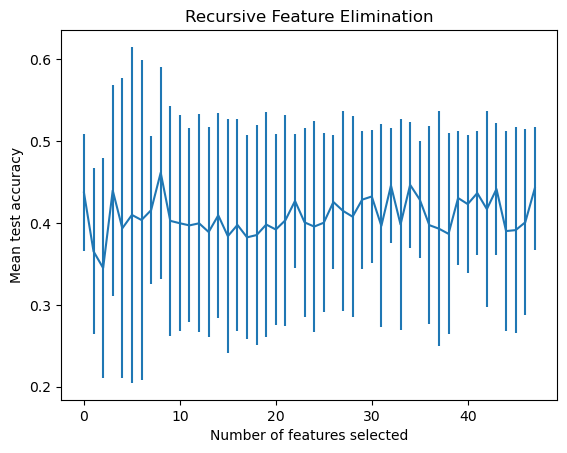

In [55]:
import matplotlib.pyplot as plt
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Mean test accuracy")
plt.errorbar(
    x=cv_results.index,
    y=cv_results["mean_test_score"],
    yerr=cv_results["std_test_score"],
)
plt.title("Recursive Feature Elimination")
plt.show()

In [57]:
df6=pd.concat([df4.participantId,df4.activity,df4[rfecv.get_feature_names_out(X.columns)]],axis=1).dropna()
df6

,participantId,activity,activity_count,acceleration.y_max,acceleration.z_var,acceleration.z_min,accelerationIncludingGravity.x_min,accelerationIncludingGravity.x_median,accelerationIncludingGravity.y_max,accelerationIncludingGravity.z_max,rotationRate.alpha_var
0,10d83,sitting,60.0,0.2,0.033955,-0.3,-0.9,-0.65,8.6,5.6,4.486879
1,10d83,sitting,61.0,0.2,0.033503,-0.3,-0.9,-0.60,8.6,5.6,4.555568
2,10d83,sitting,60.0,0.2,0.033006,-0.3,-0.9,-0.60,8.6,5.6,4.674735
3,10d83,sitting,60.0,0.2,0.032754,-0.3,-0.9,-0.60,8.6,5.6,4.801186
4,10d83,sitting,60.0,0.2,0.032754,-0.3,-0.9,-0.60,8.6,5.6,4.811127
...,...,...,...,...,...,...,...,...,...,...,...
108191,uspgb,sitting,60.0,0.0,0.000000,-0.2,-0.1,0.00,0.1,9.6,0.194404
108192,uspgb,sitting,61.0,0.0,0.000000,-0.2,-0.1,0.00,0.1,9.6,0.191525
108193,uspgb,sitting,60.0,0.0,0.000000,-0.2,-0.1,0.00,0.1,9.6,0.176497
108194,uspgb,sitting,60.0,0.0,0.000000,-0.2,-0.1,0.00,0.1,9.6,0.168768
